# Experimentation Only

In [1]:
import sys
!{sys.executable} -m pip install tqdm

You are using pip version 9.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from datetime import datetime
import datetime as dt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm, tqdm_notebook
import json
import requests
%matplotlib inline

#For Prediction
from sklearn import metrics
from sklearn import preprocessing, cross_validation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.layers import Dense, Dropout, Input, LSTM, Reshape, Flatten, Activation
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# endpoint = 'https://min-api.cryptocompare.com/data/histoday'
# res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
# hist = pd.DataFrame(json.loads(res.content.decode('utf-8'))['Data'])
# hist = hist.set_index('time')
# hist.index = pd.to_datetime(hist.index, unit='s')
# hist.head()

hist = pd.read_csv('Datasets/bitcoin_research_data_v2.csv')
hist.head()

,Unnamed: 0,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD,Popularity,Popularity_Normalized
0,0,2019-05-11,BTCUSD,6337.9,6984.8,6337.9,6793.5,9855.87,66133073.75,12.0,1200.0
1,1,2019-05-10,BTCUSD,6151.4,6430.0,6110.1,6337.9,9872.86,62166515.28,12.0,1200.0
2,2,2019-05-09,BTCUSD,5939.6,6174.0,5933.2,6151.4,7405.18,44816872.39,12.0,1200.0
3,3,2019-05-08,BTCUSD,5744.0,5983.2,5660.0,5939.6,6007.11,35184697.52,12.0,1200.0
4,4,2019-05-07,BTCUSD,5687.4,5955.8,5687.4,5906.7,3668.12,21496575.65,12.0,1200.0


In [4]:
#hist = hist.drop(['high','low','open','volumefrom','volumeto'], axis=1)
#hist = hist.drop(['Unix Timestamp','Date','Symbol','Open','High','Low','Volume'], axis=1)
#hist = hist.drop(['Date','Symbol','Unix Timestamp','Low','High'], axis=1)
hist = hist.drop(['Date','Symbol','Popularity','Volume BTC','Volume USD'], axis=1)
hist = hist.drop('Unnamed: 0', axis=1)
hist.tail()

,Open,High,Low,Close,Popularity_Normalized
1803,494.77,530.00,494.77,530.00,200.0
1804,493.43,497.67,490.85,494.77,200.0
1805,445.56,498.84,445.56,493.43,200.0
1806,445.56,445.56,445.56,445.56,200.0
1807,453.83,453.83,445.56,445.56,200.0


In [5]:
print(len(hist))

1808


In [6]:
print("checking if any null values are present\n", hist.isna().sum())

checking if any null values are present
 Open                     0
High                     0
Low                      0
Close                    0
Popularity_Normalized    0
dtype: int64


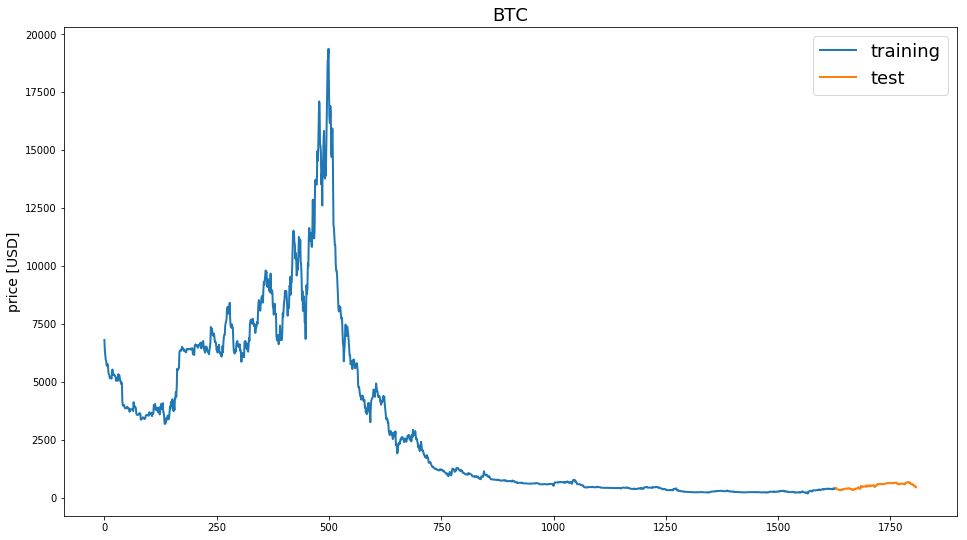

In [7]:
def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

def line_plot(line1, line2, label1=None, label2=None, title=''):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=2)
    ax.plot(line2, label=label2, linewidth=2)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)
    
train, test = train_test_split(hist, test_size=0.1)
line_plot(train.Close, test.Close, 'training', 'test', 'BTC')

In [8]:
def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with
        respect to first entry.
    """
    return df / df.iloc[0] - 1

def extract_window_data(df, window=7, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of
        length `window`.
    """
    window_data = []
    for idx in range(len(df) - window):
        tmp = df[idx: (idx + window)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

def prepare_data(df, window=7, zero_base=True, test_size=0.1):
    """ Prepare data for LSTM. """
    # train test split
    train_data, test_data = train_test_split(df, test_size)
    
    # extract window data
    X_train = extract_window_data(train_data, window, zero_base)
    X_test = extract_window_data(test_data, window, zero_base)
    
    # extract targets
    y_train = train_data.Close[window:].values
    y_test = test_data.Close[window:].values
    if zero_base:
        y_train = y_train / train_data.Close[:-window].values - 1
        y_test = y_test / test_data.Close[:-window].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test

train, test, X_train, X_test, y_train, y_test = prepare_data(hist)

In [9]:
print(X_train.shape)
print(X_train.shape)
print(y_test.shape)
print(y_test.shape)

(1621, 7, 5)
(1621, 7, 5)
(173,)
(173,)


In [10]:
TIME_STEPS = 7
BATCH_SIZE_OUT = 4 # 16 was better
LR = 0.005
# epochs = 150
EPOCHS = 50

In [11]:
def create_generator():
#     generator=Sequential()
#     generator.add(Dense(units=128,input_dim=8))
#     generator.add(LeakyReLU(0.2))
    
#     generator.add(Dense(units=256))
#     generator.add(LeakyReLU(0.2))
    
#     generator.add(Dense(units=512))
#     generator.add(LeakyReLU(0.2))
    
#     generator.add(Dense(units=8, activation='tanh'))
    
#     #generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer(), metrics=['accuracy'])
#     generator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # 6 below = x_t.shape[2]
#     generator = Sequential()
#     #generator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 6), dropout=0.0, recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform', return_sequences=False)) 
#     # stateful = true breaks the model (https://github.com/keras-team/keras/issues/9385)
#     generator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 1), return_sequences=True)) 
#     generator.add(Dense(8,activation='relu'))
#     generator.add(Dropout(0.7))
#     generator.add(LSTM(8, return_sequences=False))
#     generator.add(Dense(1,activation='sigmoid'))
#     #generator.add(Reshape((TIME_STEPS, 1)))
#     optimizer = RMSprop(lr=LR, decay=3e-8)
#     #generator.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
#     generator.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
    
    
    generator = Sequential()
    generator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 5), return_sequences=False))
    generator.add(LeakyReLU(0.5))
    generator.add(Dropout(0.5))
    generator.add(Dense(5))
    generator.add(Activation('tanh'))
    optimizer = RMSprop(lr=0.005, clipvalue=1.)
    generator.compile(loss='mean_squared_error', optimizer=optimizer)

    return generator
g=create_generator()
g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (4, 16)                   1408      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (4, 16)                   0         
_________________________________________________________________
dropout_1 (Dropout)          (4, 16)                   0         
_________________________________________________________________
dense_1 (Dense)              (4, 5)                    85        
_________________________________________________________________
activation_1 (Activation)    (4, 5)                    0         
Total params: 1,493
Trainable params: 1,493
Non-trainable params: 0
_________________________________________________________________


In [12]:
def create_discriminator():
    optimizer = RMSprop(lr=0.0002, decay=6e-8)

    discriminator=Sequential()
    #discriminator.add(Dense(units=512, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 1)))
    discriminator.add(Dense(units=16, batch_input_shape=(8, TIME_STEPS, 5)))
    
    #discriminator.add(Dense(units=512,input_dim=6))
    discriminator.add(LeakyReLU(0.5))
    discriminator.add(Dropout(0.5))
       
    
#     discriminator.add(Dense(units=256))
#     discriminator.add(LeakyReLU(0.2))
#     discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=8))
    discriminator.add(LeakyReLU(0.5))
    discriminator.add(Dropout(0.5))
    
    #discriminator.add(Reshape((5, 1)))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    #discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    discriminator.compile(loss='mean_squared_error', optimizer=optimizer)

#     discriminator = Sequential()
#     discriminator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 6), dropout=0.0, recurrent_dropout=0.0, kernel_initializer='random_uniform', return_sequences=False)) 
#     discriminator.add(Dense(8,activation='relu'))
#     discriminator.add(Dropout(0.7))
#     discriminator.add(Dense(1,activation='sigmoid'))

#     discriminator.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    
    return discriminator
d =create_discriminator()
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (8, 7, 16)                96        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (8, 7, 16)                0         
_________________________________________________________________
dropout_2 (Dropout)          (8, 7, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (8, 7, 8)                 136       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (8, 7, 8)                 0         
_________________________________________________________________
dropout_3 (Dropout)          (8, 7, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (8, 7, 1)                 9         
Total para

In [13]:
def create_gan(discriminator, generator):
    optimizer = RMSprop(lr=0.0001, decay=3e-8)
    discriminator.trainable=False
    gan_input = Input(shape=(TIME_STEPS, 5)) # x_t.shape[2] = 6
    #Input(shape=(None, latent_dim))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    #gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    gan.compile(loss='mean_squared_error', optimizer=optimizer)
    return gan
gan = create_gan(d,g)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7, 5)              0         
_________________________________________________________________
sequential_1 (Sequential)    multiple                  1493      
_________________________________________________________________
sequential_2 (Sequential)    multiple                  241       
Total params: 1,734
Trainable params: 1,493
Non-trainable params: 241
_________________________________________________________________


In [14]:
import keras.backend as K

adversarial_loss = []
discrimator_loss = []
gen_samples = []

#K.clear_session()
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator, generator)
#(X_train, y_train, X_val, X_test, y_val, y_test) = load_data(x_train_out, x_test_out, BATCH_SIZE_OUT)

def training(epochs=1, batch_size=128):
    global adversarial_loss
    global discrimator_loss
    global gen_samples
    
    global generator
    global discriminator
    global gan

    global X_train
    global X_test
    global y_train
    global y_test
    
    for e in range(1, epochs+1 ):
        print("Epoch %d" %e)
        for i in tqdm(range(batch_size)):
            #generate  random noise as an input  to  initialize the  generator
            #noise = np.random.normal(0,1, [BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]])
            #print(X_train.shape)
            
            noise = np.float32(np.random.normal(size=[BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]]))
            
            # Generate fake prices from noised input
            generated_prices = generator.predict(noise)
            
            # Get a random set of real prices
            prices_batch = X_train[np.random.randint(low=0,high=X_train.shape[0],size=BATCH_SIZE_OUT)]
            
            
            dim_0 = generated_prices.shape[0] - TIME_STEPS
            dim_0 = generated_prices.shape[0]
            gen_prices = np.zeros((dim_0, TIME_STEPS, 5))
            
            for j in range(dim_0):
                gen_prices[j] = generated_prices[j]
            

#             print('Shapes 1')
#             print(noise.shape)
#             print(prices_batch.shape)
#             print(generated_prices.shape)     
#             print(gen_prices.shape)
#             print('>>>>>>>>>>>gen_prices>>>>>>>')            
#             print(gen_prices)
#             print(prices_batch)
#             #print(generated_prices)
            
            #Construct different batches of real and fake data 
            X = np.concatenate([prices_batch, gen_prices])
            
            # Labels for generated and real data
            #y_dis = np.zeros(2*batch_size)
            #y_dis = np.zeros(shape=(2*BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]))
            y_dis = np.zeros(shape=(X.shape[0], TIME_STEPS, 1))
            #y_dis[:batch_size]=0.9
            y_dis[:int((X.shape[0]/2))]=0.9
            #y_dis[0,:,batch_size]=0.9
            
#             print('Shapes 2')
#             print(X.shape)
#             print(y_dis.shape)
#             print('>>>>>>>>>>>x>>>>>>>')
#             print(X)
#             print('>>>>>>>>>>>y_dis>>>>>>>')            
#             print(y_dis)
            
            #Pre train discriminator on fake and real data before starting the gan. 
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            #noise = np.random.normal(0,1, [batch_size, 8])
            #y_gen = np.ones(batch_size)
            noise = np.float32(np.random.normal(size=[BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]]))
            #y_gen = np.ones(shape=(noise.shape[0], TIME_STEPS, X_train.shape[2]))
            y_gen = np.ones(BATCH_SIZE_OUT)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
#             print('Shapes 3')
#             print(noise.shape)
#             print(y_gen.shape)
            
            #training the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            a_loss = gan.train_on_batch(noise, y_gen)
            
            if i == (batch_size-1):
                #log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
                #log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
                log_mesg = "%d: [D loss: %f]" % (e, d_loss)
                log_mesg = "%s  [A loss: %f]" % (log_mesg, a_loss)
                print(log_mesg)
                
            discrimator_loss.append(d_loss)
            adversarial_loss.append(a_loss)
            
#         if e == 1 or e % 5 == 0:
#             # generate synthetic dataset
#             gen_samples_set = []
#             for batch_idx in range(int(len(X_train) / batch_size)):
#             # for batch_idx in range(int(len(X_train) / 100)):
#                 # noise= np.random.normal(loc=0, scale=1, size=[100, 100])
#                 #noise= np.random.normal(0,1, [batch_size, 8])
#                 noise = np.float32(np.random.normal(size=[BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]]))
#                 generated_data = generator.predict(noise)
#                 gen_samples_set.append(generated_data)

#             gen_samples = np.vstack(gen_samples_set)

In [15]:
#training(400,128)
training(50,12)

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1


  0%|          | 0/12 [00:00<?, ?it/s]

1: [D loss: 0.205673]  [A loss: 0.261061]
Epoch 2
2: [D loss: 0.209765]  [A loss: 0.261604]
Epoch 3


  0%|          | 0/12 [00:00<?, ?it/s]

3: [D loss: 0.198980]  [A loss: 0.255375]
Epoch 4
4: [D loss: 0.206978]  [A loss: 0.285367]
Epoch 5


  0%|          | 0/12 [00:00<?, ?it/s]

5: [D loss: 0.200089]  [A loss: 0.246931]
Epoch 6
6: [D loss: 0.211511]  [A loss: 0.277504]
Epoch 7


  0%|          | 0/12 [00:00<?, ?it/s]

7: [D loss: 0.196366]  [A loss: 0.275905]
Epoch 8
8: [D loss: 0.213402]  [A loss: 0.312790]
Epoch 9


  0%|          | 0/12 [00:00<?, ?it/s]

9: [D loss: 0.202024]  [A loss: 0.317151]
Epoch 10
10: [D loss: 0.204770]  [A loss: 0.285912]
Epoch 11


  0%|          | 0/12 [00:00<?, ?it/s]

11: [D loss: 0.187444]  [A loss: 0.294355]
Epoch 12
12: [D loss: 0.191887]  [A loss: 0.293962]
Epoch 13


  0%|          | 0/12 [00:00<?, ?it/s]

13: [D loss: 0.201171]  [A loss: 0.309245]
Epoch 14
14: [D loss: 0.204177]  [A loss: 0.286114]
Epoch 15


  0%|          | 0/12 [00:00<?, ?it/s]

15: [D loss: 0.204244]  [A loss: 0.272369]
Epoch 16
16: [D loss: 0.198759]  [A loss: 0.307910]
Epoch 17


  0%|          | 0/12 [00:00<?, ?it/s]

17: [D loss: 0.194910]  [A loss: 0.302265]
Epoch 18
18: [D loss: 0.207259]  [A loss: 0.266719]
Epoch 19


  0%|          | 0/12 [00:00<?, ?it/s]

19: [D loss: 0.208622]  [A loss: 0.288531]
Epoch 20
20: [D loss: 0.204440]  [A loss: 0.298380]
Epoch 21


  0%|          | 0/12 [00:00<?, ?it/s]

21: [D loss: 0.202177]  [A loss: 0.271038]
Epoch 22
22: [D loss: 0.201084]  [A loss: 0.279295]
Epoch 23


  0%|          | 0/12 [00:00<?, ?it/s]

23: [D loss: 0.201335]  [A loss: 0.282209]
Epoch 24
24: [D loss: 0.201087]  [A loss: 0.347720]
Epoch 25


  0%|          | 0/12 [00:00<?, ?it/s]

25: [D loss: 0.199761]  [A loss: 0.272705]
Epoch 26
26: [D loss: 0.200459]  [A loss: 0.305009]
Epoch 27


  0%|          | 0/12 [00:00<?, ?it/s]

27: [D loss: 0.194497]  [A loss: 0.317890]
Epoch 28
28: [D loss: 0.205549]  [A loss: 0.333351]
Epoch 29


  0%|          | 0/12 [00:00<?, ?it/s]

29: [D loss: 0.203636]  [A loss: 0.299074]
Epoch 30
30: [D loss: 0.202734]  [A loss: 0.303154]
Epoch 31


100%|██████████| 12/12 [00:00<00:00, 68.67it/s]

31: [D loss: 0.197969]  [A loss: 0.283120]
Epoch 32
32: [D loss: 0.208879]  [A loss: 0.288748]
Epoch 33



 58%|█████▊    | 7/12 [00:00<00:00, 64.63it/s]

33: [D loss: 0.199099]  [A loss: 0.312347]
Epoch 34


  0%|          | 0/12 [00:00<?, ?it/s]

34: [D loss: 0.201314]  [A loss: 0.340562]
Epoch 35
35: [D loss: 0.206192]  [A loss: 0.391801]
Epoch 36


  0%|          | 0/12 [00:00<?, ?it/s]

36: [D loss: 0.197238]  [A loss: 0.275197]
Epoch 37
37: [D loss: 0.203976]  [A loss: 0.285114]
Epoch 38


  0%|          | 0/12 [00:00<?, ?it/s]

38: [D loss: 0.194823]  [A loss: 0.313808]
Epoch 39
39: [D loss: 0.193282]  [A loss: 0.317445]
Epoch 40


  0%|          | 0/12 [00:00<?, ?it/s]

40: [D loss: 0.207547]  [A loss: 0.300188]
Epoch 41
41: [D loss: 0.201303]  [A loss: 0.289419]
Epoch 42


  0%|          | 0/12 [00:00<?, ?it/s]

42: [D loss: 0.202367]  [A loss: 0.296092]
Epoch 43
43: [D loss: 0.204887]  [A loss: 0.269471]
Epoch 44


  0%|          | 0/12 [00:00<?, ?it/s]

44: [D loss: 0.199088]  [A loss: 0.300844]
Epoch 45
45: [D loss: 0.201388]  [A loss: 0.308727]
Epoch 46


  0%|          | 0/12 [00:00<?, ?it/s]

46: [D loss: 0.206638]  [A loss: 0.263815]
Epoch 47
47: [D loss: 0.208328]  [A loss: 0.335493]
Epoch 48


  0%|          | 0/12 [00:00<?, ?it/s]

48: [D loss: 0.198500]  [A loss: 0.272382]
Epoch 49
49: [D loss: 0.200977]  [A loss: 0.297411]
Epoch 50


100%|██████████| 12/12 [00:00<00:00, 66.45it/s]

50: [D loss: 0.204086]  [A loss: 0.353619]


Text(0,0.5,'Loss')

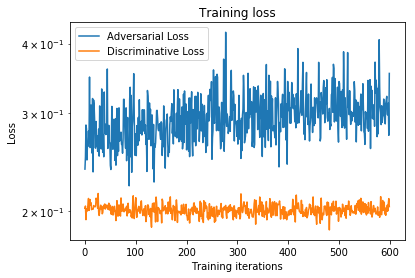

In [16]:
# adversarial_loss_map = get_2D_array_values(adversarial_loss, 0)
# discrimator_loss_map = get_2D_array_values(discrimator_loss, 0)

ax = pd.DataFrame(
    {
        'Adversarial Loss': adversarial_loss,
        'Discriminative Loss': discrimator_loss,
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Training iterations")
ax.set_ylabel("Loss")

In [72]:
targets = test.Close[7:]
preds = gan.predict(X_test).squeeze()

In [68]:
# Should look at other metrics as well (MSE, RMSE, Accuracy)
metrics.mean_absolute_error(preds, y_test)

0.44986715739030697

In [43]:
from scipy.stats import ks_2samp
value, pvalue = ks_2samp(y_test, preds)
print("test statistic =", value, "  ", "pvalue = ", pvalue)

test statistic = 1.0    pvalue =  1.054624125277201e-77


In [44]:
if pvalue > 0.05:
	print('Samples are likely drawn from the same distributions (not reject H0)')
else:
	print('Samples are likely drawn from different distributions (reject H0)')

Samples are likely drawn from different distributions (reject H0)


             Fake        Real
count  173.000000  173.000000
mean     0.465708    0.015841
std      0.001154    0.094070
min      0.460838   -0.236008
25%      0.465416   -0.030227
50%      0.466065    0.010847
75%      0.466449    0.065372
max      0.467065    0.272694


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffb1b7a24a8>,
      dtype=object)

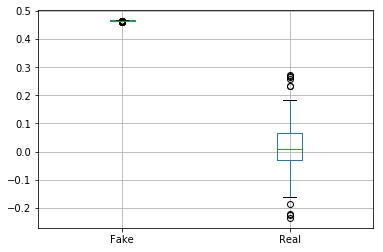

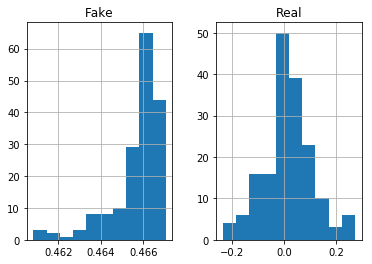

In [45]:
results = pd.DataFrame({'Real':y_test, 'Fake': preds})

# statistics summary
print(results.describe())
# boxplot
results.boxplot()

results.hist(bins=10)

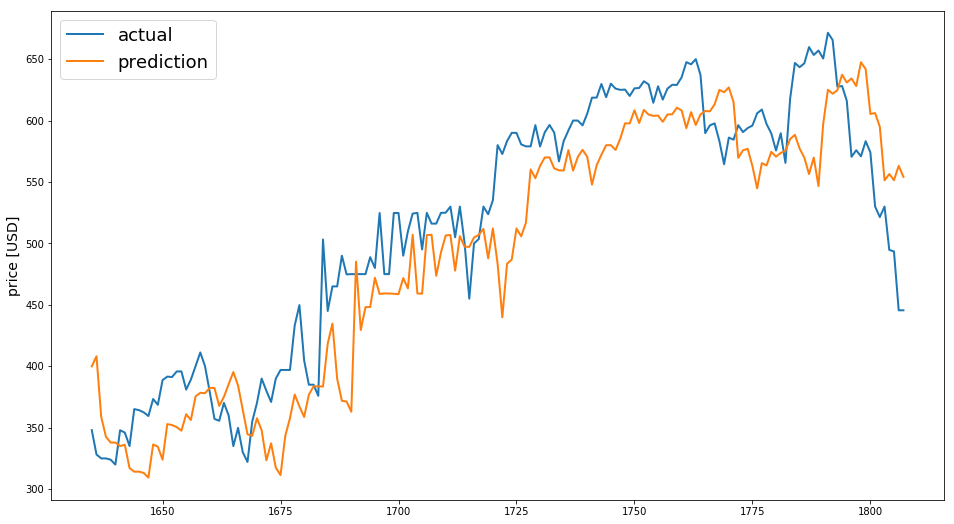

In [73]:
# preds = test.Close.values[:-7] * (preds + 1) # random adjustment value = mae
preds = test.Close.values[:-7] * (preds + 0.5) 
preds = pd.Series(index=targets.index, data=preds)

line_plot(targets, preds, 'actual', 'prediction')

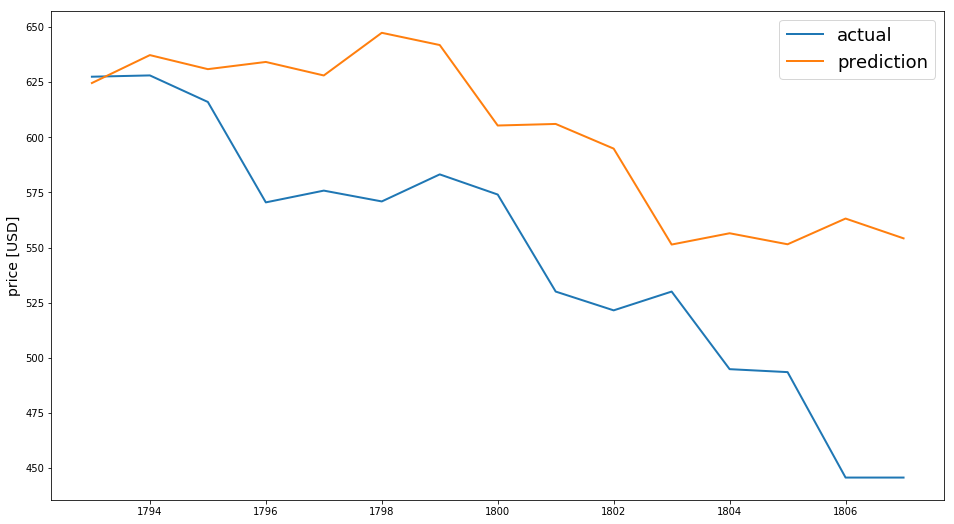

In [76]:
n_points = 15

line_plot(targets[-n_points:], preds[-n_points:], 'actual', 'prediction')